# Monkeys in abstract syntax trees

**Note:** This tutorial assumes a working knowledge of Python abstract syntax trees; if you are not familiar with Python ASTs, [Green Tree Snakes](https://greentreesnakes.readthedocs.io/en/latest/) serves as an excellent introduction, and the [Python AST explorer](https://python-ast-explorer.com/) allows you to view ASTs for arbitrary Python code interactively. This tutorial also assumes you have already read [Getting started with monkeys](Getting%20started%20with%20monkeys.ipynb).

In this notebook, we'll use `monkeys` to generate Python code directly. In order to do so, rather than specifying functions to manipulate values directly, we'll be using functions which take and return AST nodes, and in this way build up an executable program.

Let's try to evolve the built-in function `abs`. We'll first want to introduce some numerical constants. However, rather than doing e.g. `constant(int, 0)`, we'll want to have AST-node representations, a la:

In [1]:
from monkeys.typing import constant
import ast

zero = constant(ast.Num, ast.Num(n=0))
one = constant(ast.Num, ast.Num(n=1))

We also want to have an input - however, rather than using `make_input`, we'll accomplish this by referencing a named parameter in the function we're building. We'll call this `x`. While `x` is an `ast.Name` node, we know it will always be numeric - so we can provide a no-op means of converting it to an `ast.Num`.

In [2]:
from monkeys.typing import params, rtype

x = constant(ast.Name, ast.Name(id='x', ctx=ast.Load()))

@params(ast.Name)
@rtype(ast.Num)
def name_as_num(name_node):
    return name_node

We know that we also want to have a means of negating numbers. One way of accomplishing this is the following:

In [3]:
from monkeys.typing import params, rtype

@params(ast.Num)
@rtype(ast.Num)
def negate(num_node):
    return ast.Expr(
        value=ast.UnaryOp(
            op=ast.USub(),
            operand=num_node
        )
    )

However, that's a pretty verbose way of representing simple negation - and as we introduce more complex constructs, we'll quickly find ourselves overwhelmed by boilerplate. Thankfully, `monkeys` provides an easy means of creating "quoted" templates - functions  where the value returned is an AST representation of the function body with specified values replaced. For example, to create the equivalent of the `negate` function declared above, we can simply do:

In [4]:
from monkeys.asts import quoted_template

@params(ast.Num)
@rtype(ast.Num)
@quoted_template
def negate_v2(num):
    -(num)

We can see that both methods return nearly the same result - the primary difference being that `negate_v2` returns a list of nodes, whereas `negate` returns a single node:

In [5]:
negated_x = negate(x)
negated_v2_x, = negate_v2(x)
ast.dump(negated_x), ast.dump(negated_v2_x)

("Expr(value=UnaryOp(op=USub(), operand=Name(id='x', ctx=Load())))",
 "Expr(value=UnaryOp(op=USub(), operand=Name(id='x', ctx=Load())))")

This isn't anything to worry about: `monkeys` is designed to handle both styles. Since it's superfluous, let's remove `negate`:

In [6]:
from monkeys.typing import deregister
deregister(negate)

Now, let's make a few more quoted templates:

In [7]:
@params(ast.Num, ast.Num)
@rtype(ast.Num)
@quoted_template
def multiply(a, b):
    a * b    
    
@params(ast.Num, ast.Num)
@rtype(ast.Compare)
@quoted_template
def gte(a, b):
    a >= b
    
@params(ast.Num, ast.Compare, ast.Num)
@rtype(ast.Num)
@quoted_template
def if_else(true_num, cond, false_num):
    true_num if cond else false_num

@params(ast.Num)
@rtype(ast.FunctionDef)
@quoted_template
def function_def(num):
    def my_abs(x):
        return int(num)

We'll also need to add a final non-quoted function to convert our function definition to an executable module:

In [8]:
@params(ast.FunctionDef)
@rtype(ast.Module)
def module(fn):
    return ast.Module(
        body=fn if isinstance(fn, list) else [fn]
    )

Let's now visualize our types before proceeding:

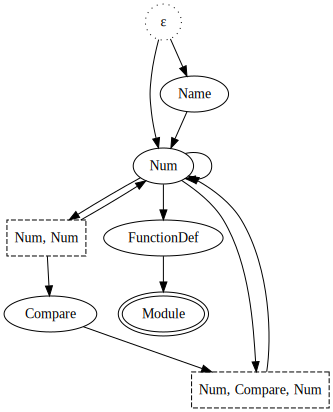

In [9]:
from monkeys.display import type_graph
type_graph()

We can now define a scoring function and optimize. Because we didn't use any input nodes, we can use the `pre_evaluate` decorator to simplify our scoring function. We'll also use the `assertions_as_score` decorator, which assigns a score based on the number of `assert`-based tests in our function body which pass.

In [10]:
from monkeys.search import pre_evaluate, assertions_as_score, optimize

@params(ast.Module)
@pre_evaluate
@assertions_as_score
def score(module):
    exec(compile(module, '<string>', 'exec'))
    assert my_abs(0) == 0
    assert my_abs(1) == 1
    assert my_abs(-1) == 1
    assert my_abs(3) == 3
    assert my_abs(-3) == 3

best_abs = optimize(score, iterations=25)

Creating initial population of 250.
Optimizing...
Iteration 1:	Best: 3.00	Average: 1.00
Iteration 2:	Best: 4.00	Average: 2.00
Iteration 3:	Best: 4.00	Average: 3.00
Iteration 4:	Best: 4.00	Average: 3.00
Iteration 5:	Best: 4.00	Average: 3.00
Iteration 6:	Best: 4.00	Average: 3.00
Iteration 7:	Best: 4.00	Average: 3.00
Iteration 8:	Best: 4.00	Average: 3.00
Iteration 9:	Best: 4.00	Average: 3.00
Iteration 10:	Best: 4.00	Average: 3.00
Iteration 11:	Best: 4.00	Average: 3.00
Iteration 12:	Best: 4.00	Average: 3.00
Iteration 13:	Best: 4.00	Average: 3.00
Iteration 14:	Best: 4.00	Average: 3.00
Iteration 15:	Best: 4.00	Average: 3.00
Iteration 16:	Best: 4.00	Average: 3.00
Iteration 17:	Best: 4.00	Average: 3.00
Iteration 18:	Best: 5.00	Average: 3.00


As we can see, `optimize` can tell at the end of 18 iterations that we've reached our maximum score, and stops the optimization process early. To show the final source code result, we'll use the third-party library `astor`:

In [11]:
import astor
print astor.to_source(best_abs.evaluate())

def my_abs(x):
    return int((x if (x >= ((- x) * 1)) else (- x)))
